In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from bs4 import BeautifulSoup
from datetime import timedelta
from scipy.stats import expon

In [93]:
import yfinance as yf

In [3]:
stock_vip_free_chat = json.load(open('stock_vip_free_chat.json'))

In [4]:
def return_cleaned_messages(full_json):
    messages = pd.DataFrame(full_json["messages"])
    messages['id'] = messages['id'].astype(int)
    messages['timestamp'] = messages['timestamp'].apply(lambda x: pd.to_datetime(x).tz_convert(tz='US/Pacific').tz_localize(None))
    messages['author_id'] = messages['author'].apply(lambda x: int(x['id']))
    messages['author_name'] = messages['author'].apply(lambda x: x['name'])
    messages['is_bot'] = messages['author'].apply(lambda x: x['isBot'])
    messages = messages.loc[messages['is_bot'] == False].reset_index(drop=True)
    
    return messages

In [5]:
stock_vip_free_chat = return_cleaned_messages(stock_vip_free_chat)

In [6]:
import nltk
from nltk.corpus import words

### variables that might effect next day percent returns
#### general variables
-avg length of a message mentioning a ticker
-avg number of stocks mentioned in that message with ticker
-percent of ticker messages that ticker is in
-percent of messages with tickers
-previous movements of that stock (previous day's change)
-average number of replies/likes to each message
-the number of distinct users mentioning the ticker
-the number of posts by the most frequent poster
-Each of these variables split from during trading hours and after trading hours

#### variables particular to stock
-Previous day return, volatility (maybe abs(high - low) is better)
-5 Day moving avg volume
-That days trading volume
-the distribution of the tickers over time (ie. spread out/independent or in response)


note: could look at two strategies, buy before close or buy at open...
for now will just look at 

### want a model that finds potential pump stocks before they're popular
#### model only runs Tuesday-Friday (would have to figure out weekend effect otherwise...)

check if linear regression on percent returns

In [77]:
# df = stock_vip_free_chat.loc[stock_vip_free_chat['date'] == pd.Timestamp('2021-01-28')].reset_index(drop=True)

In [7]:
texting_words = ['lol', 'guys', 'lmao', 'shit', 'fuck', 'yall', 'bruh', 'lets', 'app', 'hype', 'okay','boys', \
                 'cuz', 'imma', 'isnt', 'tmrw', 'gets', 'says', 'ayo', 'ik', 'abt', 'omg', 'stfu', 'goin', 'info', \
                 'puts', 'spam', 'mins', 'buys', 'af', 'itll', 'yup', 'xd', 'cars', 'kid', 'mf', 'meme', 'held', \
                 'lil', 'whos', 'ight', 'paid', 'btw', 'mod', 'atm', 'dms', 'bois', 'wins', 'ears', 'gooo', 'jk' \
                 'asap', 'wdym', 'tik', 'cmon', 'jus', 'pics', 'spac', 'max', 'uh', 'gg', 'oof', 'tok', 'mods', \
                 'hehe', 'rlly', 'etc', 'tm', 'bets', 'thru', 'syn', 'tbh', 'pre', 'asf', 'jk', 'mans', 'asap', \
                 'im', 'rn', 'vip', 'has', 'bro', 'dm', 'mvp', 'ok', 'idk', 'nah', 'haha', 'gf', 'hmm', 'oct', \
                 'wtf', 'fr', 'hits', 'bc', 'tf', 'xl', 'elon', 'ive', 'ima', 'ppl', 'td', 'wym', 'ez', \
                 'ev', 'kids', 'smh', 'pls', 'wsb', 'imo', 'jan', 'uk', 'ones', 'mom', 'apps', \
                 'def', 'hes', 'alot', 'ipo', 'thx', 'est', 'ty', 'plz', 'fax', 'pm', 'ngl', 'sus', \
                 'ig', 'nvm', 'ceo', 'haz', 'gn', 'mars', 'yolo', 'ofc', 'lmk', 'ahh', 'pc', 'vc', \
                 'hbu', 'obv', 'hola', 'upp', 'hiii', 'et', 'calc', 'porn', 'bmw', 'ipod', 'guns', 'etf', \
                 'vips', 'ohh', 'idc', 'dec', 'cali', 'soo', 'usa', 'vs', 'bio', 'feb', 'np', 'iq', 'gl' \
                 'dips', 'tmr', 'spaq', 'btc', 'xrp', 'nuts', 'pfp', 'mfs', 'abnb', 'alr', 'mexi', 'ivan', \
                 'owa', 'uone', 'ipoc', 'uwmc', 'dips']

In [8]:
setofwords = set(words.words())

In [9]:
def extract_tickers(s):
    words = s.lower().split(' ')
    tickers = [word for word in words if len(word) < 5 and word.isalpha() and word not in setofwords]
    tickers = [ticker for ticker in tickers if ticker not in texting_words]
    
    return tickers 

In [10]:
stock_vip_free_chat['tickers'] = stock_vip_free_chat['content'].apply(lambda x: extract_tickers(x))

In [11]:
# take out the most frequent tickers
all_tickers = [item for sublist in stock_vip_free_chat['tickers'].to_list() for item in sublist]
counts = pd.DataFrame(pd.Series(all_tickers).value_counts()).reset_index().rename(columns={'index': 'stock', 0: 'count'})

In [12]:
not_stocks = counts.loc[counts['count'] < 450, 'stock'].to_list()
texting_words = set(list(texting_words) + not_stocks)

In [13]:
stock_vip_free_chat = stock_vip_free_chat.drop(columns=['tickers']) 
stock_vip_free_chat['tickers'] = stock_vip_free_chat['content'].apply(lambda x: extract_tickers(x))

In [14]:
all_tickers = [item for sublist in stock_vip_free_chat['tickers'].to_list() for item in sublist]
pd.DataFrame(pd.Series(all_tickers).value_counts()).reset_index().rename(columns={'index': 'stock', 0: 'count'})

stock  count
0    amc  58729
1    nio  42802
2   sndl  26110
3    nok  22008
4    zom  19868
..   ...    ...
82  ctic    480
83  zsan    479
84  ftek    461
85  novn    455
86  mvis    453

[87 rows x 2 columns]

In [15]:
stock_vip_free_chat['message_len'] = stock_vip_free_chat['content'].apply(lambda x: len(x))
stock_vip_free_chat['n_words'] = stock_vip_free_chat['content'].apply(lambda x: len(x.split(' ')))
stock_vip_free_chat['n_tickers'] = stock_vip_free_chat['tickers'].apply(lambda x: len(x))
stock_vip_free_chat['n_replies'] = stock_vip_free_chat['mentions'].apply(lambda x: len(x))
stock_vip_free_chat['n_reactions'] = stock_vip_free_chat['reactions'].apply(lambda x: len(x))

### check for patterns in arrival of messages

In [16]:
# t = stock_vip_free_chat[stock_vip_free_chat['tickers'].apply(lambda x: "amc" in x)].reset_index(drop=True) 

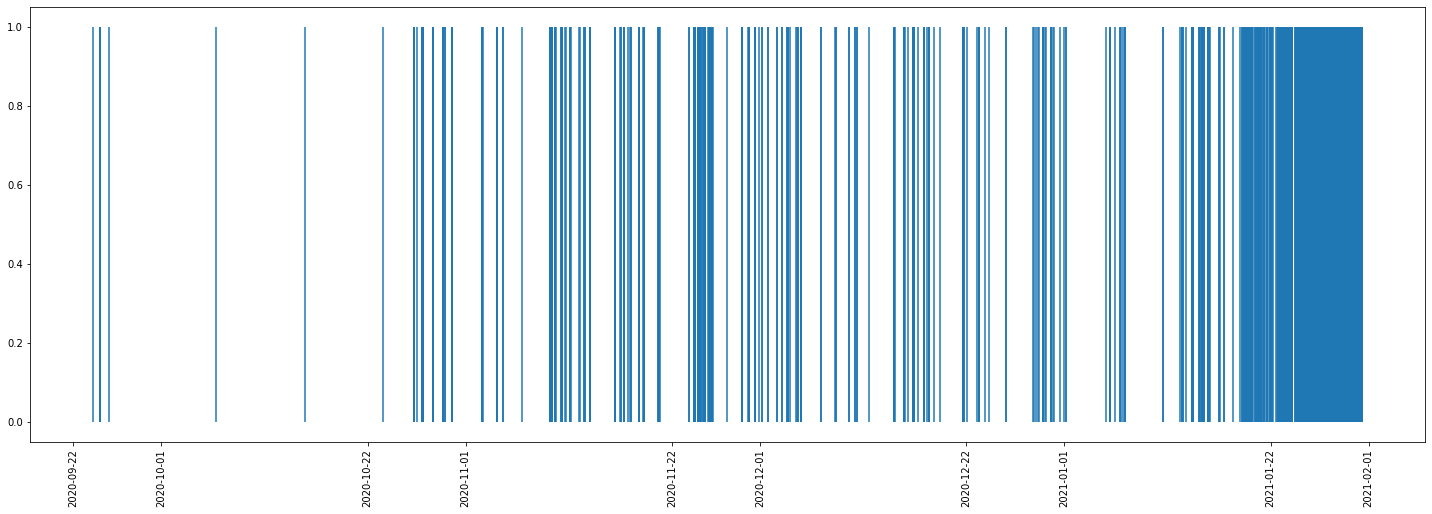

In [61]:
# fig, ax = plt.subplots(figsize=(25,8))
# ax.vlines(t['timestamp'].values, ymin = 0, ymax= 1)
# plt.xticks(rotation=90)
# plt.show()

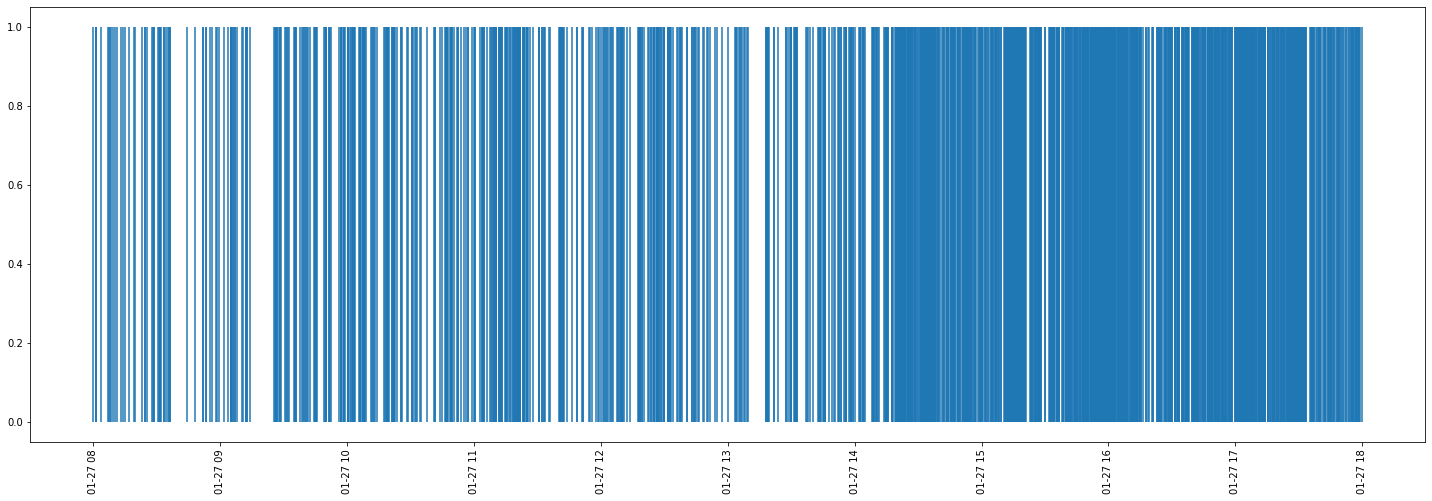

In [197]:
# t = stock_vip_free_chat[stock_vip_free_chat['tickers'].apply(lambda x: "gme" in x)].reset_index(drop=True) 
# t = t.loc[(t['timestamp'] > '2021-01-27') & (t['timestamp'] < '2021-01-27 10:00:00')].reset_index(drop=True)
# fig, ax = plt.subplots(figsize=(25,8))
# ax.vlines(t['timestamp'].values, ymin = 0, ymax= 1)
# plt.xticks(rotation=90)
# plt.show()

In [16]:
# determine how outside the norm this is
def get_expo_z_score(l, n, emperical_var): # divide by stdev
    local_emp_vars = []
    for i in range(1000):
        r = expon.rvs(scale=1/l, size=n)
        local_l = 1 / np.mean(r)
        local_emp_vars.append((np.mean(r ** 2) - (1 / local_l) ** 2))
    
    return (emperical_var - (1/l**2)) / np.std(local_emp_vars) # the z-score

In [17]:
def get_ratio_of_variance(times, as_timestamps = False):
    """ determine how clustered the arrival times are - finds how much higher the variance is 
    than would be expected by iid expo() arrival times. gets z score. higher value -> more clusters
    """
    if len(times) < 10:
        return 0
    elif as_timestamps:
        time_diffs = np.array([(times[i] - times[i-1]).astype('timedelta64[s]').astype(np.int32) for i in range(1,len(times))])
    else:
        time_diffs = np.array([(times[i] - times[i-1]) for i in range(1,len(times))])
        
    l = 1 / np.mean(time_diffs)
    emperical_var = (np.mean(time_diffs ** 2) - (1 / l) ** 2) 
    
    return get_expo_z_score(l, len(times), emperical_var) # 

In [18]:
stock_vip_free_chat['date'] = stock_vip_free_chat['timestamp'].apply(lambda x: x.date())

In [19]:
stock_to_history = {}

In [43]:
# for a trading day, extract the statistics
def extract_general_stats_for_day(df):
    tickers_df = df.loc[df['n_tickers'] > 0].reset_index(drop=True)
    non_tickers_df = df.loc[df['n_tickers'] == 0].reset_index(drop=True)

    ticker_over_non_ticker_message_len_ratio = np.log(np.mean(tickers_df['message_len']) / np.mean(non_tickers_df['message_len']) + 1)
    avg_stocks_mentioned = np.mean(tickers_df['n_tickers'])
    percent_ticker_messages = tickers_df.shape[0] / df.shape[0]
    
    ticker_over_non_ticker_replies_ratio = np.log(np.mean(tickers_df['n_replies']) / np.mean(non_tickers_df['n_replies']) + 1)
    ticker_over_non_ticker_reactions_ratio = np.log(np.mean(tickers_df['n_reactions']) / np.mean(non_tickers_df['n_reactions']) + 1)
    ticker_over_non_ticker_distinct_users_ratio = np.log(len(set(tickers_df['author_id'])) / len(set(non_tickers_df['author_id'])) + 1)
    
    all_tickers = [item for sublist in tickers_df['tickers'].to_list() for item in sublist]
    percent_posts_on_biggest_ticker = pd.Series(all_tickers).value_counts()[0] / len(all_tickers)
    
    return pd.DataFrame({'len_ratio': [ticker_over_non_ticker_message_len_ratio],
                         'avg_stocks_mentioned': [avg_stocks_mentioned],
                         'percent_ticker_messages': [percent_ticker_messages],
                         'replies_ratio': [ticker_over_non_ticker_replies_ratio],
                         'reactions_ratio': [ticker_over_non_ticker_reactions_ratio],
                         'users_ratio': [ticker_over_non_ticker_distinct_users_ratio],
                         'biggest_ticker': [percent_posts_on_biggest_ticker]})

# extracting stock specific info
def extract_ticker_specific_stats(df, ticker, column_const = ''):
    if df.shape[0] == 0:
        return
    ticker = ticker.lower()
    
    # previous_week_swing = np.mean((previous_week_df['High'] - previous_week_df['Low']) / previous_week_df['High'])
    # swing_ratio = np.log(daily_swing / previous_week_swing)
    # extract stats from words 
    
    ticker_df = df[df['tickers'].apply(lambda x: ticker in x)]
    ticker_df_original_indices = np.array(ticker_df.index) # for message arrival distribution
    ticker_df = ticker_df.reset_index(drop=True)
    other_tickers_df = df[df['tickers'].apply(lambda x: (ticker not in x) and (len(x) > 0))].reset_index(drop=True)
    
    perc_ticker_messages = ticker_df.shape[0] / (other_tickers_df.shape[0] + ticker_df.shape[0])
    ticker_len_ratio = np.log(np.mean(ticker_df['message_len']) / np.mean(other_tickers_df['message_len']))
    avg_stocks_mentioned = np.mean(ticker_df['n_tickers'])
    avg_ticker_replies = np.mean(ticker_df['n_replies']) / (np.mean(other_tickers_df['n_replies']) + 1)
    avg_ticker_reactions = np.mean(ticker_df['n_reactions']) / (np.mean(other_tickers_df['n_reactions']) + 1)
    most_active_user = pd.Series(ticker_df['author_id']).value_counts().values[0] / ticker_df.shape[0]
    
    # checking how the tickers are distributed over time - ratio of actual arrival time variance / expected variance for expo
    message_arrival_series = ticker_df_original_indices + np.random.random_sample(len(ticker_df_original_indices))
    message_clustering = get_ratio_of_variance(message_arrival_series)

    df = pd.DataFrame({'perc_ticker_messages': [perc_ticker_messages], 'ticker_len_ratio': [ticker_len_ratio],
                         'avg_ticker_stocks_mentioned': [avg_stocks_mentioned], 'avg_ticker_replies': [avg_ticker_replies],
                         'avg_ticker_reactions': [avg_ticker_reactions], 'most_active_user': [most_active_user],
                         'message_clustering': [message_clustering]})
    
    df.columns = [col + column_const for col in df.columns]
    
    return df

In [21]:
stock_info = {}

In [136]:
def get_stocks_daily_performance(df, ticker):
    if df.shape[0] == 0:
        return
    date = str(df.loc[0,'timestamp'].date())
    ticker = ticker.lower()
    # print(ticker)
    if ticker not in stock_to_history.keys():
        stock_to_history[ticker] = yf.Ticker(ticker).history(period="1Y")
    
    if ticker not in stock_info.keys():
        stock_info[ticker] = yf.Ticker(ticker).info
    
    daily_return = (stock_to_history[ticker].loc[date]['Close'] - 
                      stock_to_history[ticker].loc[date]['Open']) / stock_to_history[ticker].loc[date]['Open']
    daily_swing = (stock_to_history[ticker].loc[date]['High'] - 
                      stock_to_history[ticker].loc[date]['Low']) / stock_to_history[ticker].loc[date]['High']
    next_day = str(pd.Timestamp(date) + timedelta(days=1))[:10]
    next_day_return = (stock_to_history[ticker].loc[next_day]['Close'] - 
                      stock_to_history[ticker].loc[next_day]['Open']) / stock_to_history[ticker].loc[next_day]['Open']
    
    previous_week_df = stock_to_history[ticker].loc[
        str(pd.Timestamp(date) - timedelta(days=7))[:10]:str(pd.Timestamp(date) - timedelta(days=1))[:10]]  
    # print(previous_week_df.shape[0])
    previous_week_volume = np.mean(previous_week_df['Volume'])
    
    closing_price = np.log(stock_to_history[ticker].loc[date]['Close'] + 1) # add one for penny stocks linearity
    try:
        market_cap = np.log(stock_info[ticker]['sharesOutstanding'] * closing_price)
    except:
        market_cap = pd.NA
    
    log_volume = np.log(stock_to_history[ticker].loc[date]['Volume'] + 1)
    volume_diff = log_volume - np.log(previous_week_volume + 1)
    
    return pd.DataFrame({'daily_return': [daily_return], 'daily_swing': [daily_swing],
                         'log_volume': [log_volume], 'volume_diff': [volume_diff],
                         'next_day_return': [next_day_return], 'closing_price': [closing_price],
                         'market_cap': [market_cap]})

In [23]:
# get days to test...
trading_days = yf.Ticker('gme').history(period='3mo').index
# want to get all days in the last two months where day and the next day exists
days_to_test = []
for day in trading_days:
    if day + timedelta(days=1) in trading_days and day < pd.Timestamp('2021-01-30'):
        days_to_test.append(day)

In [137]:
def get_relevent_stocks(df, thresh = 10):
    """ get stocks mentioend in AM and PM """
    market_hours_df = df.loc[(df['timestamp'] >= (day + timedelta(hours=6.5))) & 
                             (df['timestamp'] < (day + timedelta(hours=13)))].reset_index(drop=True)
    market_hours_tickers = [item for sublist in market_hours_df['tickers'].to_list() for item in sublist]
    after_market_df = df.loc[(df['timestamp'] >= (day + timedelta(hours=13))) & 
                             (df['timestamp'] < (day + timedelta(hours=24)))].reset_index(drop=True)
    after_market_tickers = [item for sublist in after_market_df['tickers'].to_list() for item in sublist]
    # at least one in each time frame
    all_tickers = [ticker for ticker in market_hours_tickers + after_market_tickers if (
        ticker in after_market_tickers) and (ticker in market_hours_tickers)]
    
    counts = pd.DataFrame(pd.Series(all_tickers).value_counts()).reset_index().rename(columns={'index': 'stock', 0: 'count'})
    stocks = counts.loc[counts['count'] > thresh, 'stock'].to_list()
    stocks = [stock for stock in stocks if stock not in ['jmia', 'uavs', 'acb', 'ghiv']]
    
    return stocks

In [51]:
# df = stock_vip_free_chat.loc[stock_vip_free_chat['date'] == days_to_test[0]].reset_index(drop=True)
# # df['timestamp'] = df['timestamp'].apply(lambda x: x.tz_localize(None))
# stock = 'gme'
# daily_performance = get_stocks_daily_performance(df, stock)

2020-11-09


In [138]:
output = []
for day in days_to_test:
    print('-', end='')
    df = stock_vip_free_chat.loc[stock_vip_free_chat['date'] == day].reset_index(drop=True)
    general_stats = extract_general_stats_for_day(df)
    # for each stock
    stocks = get_relevent_stocks(df)
    for stock in stocks:
#         try:
            # get specific stock info
        daily_performance = get_stocks_daily_performance(df, stock)
        # get during market hours chat info
        market_hours_df = df.loc[(df['timestamp'] >= (day + timedelta(hours=6.5))) & 
                           (df['timestamp'] < (day + timedelta(hours=13)))].reset_index(drop=True)
        market_hours_stats = extract_ticker_specific_stats(market_hours_df, stock) #, column_const = '_MARKET')
        # get after market hours till midnight chat info
        after_market_df = df.loc[(df['timestamp'] >= (day + timedelta(hours=13))) & 
                                 (df['timestamp'] < (day + timedelta(hours=24)))].reset_index(drop=True)
        after_hours_stats = extract_ticker_specific_stats(after_market_df, stock) #, column_const = '_AFTER')
        mean_stats = pd.concat([market_hours_stats, after_hours_stats]).groupby(level=0).mean()
        ratio_stats_cols = [col + '_RATIO' for col in market_hours_stats.columns]
        # print(after_hours_stats.to_numpy().flatten() / market_hours_stats.to_numpy().flatten())
        ratio_stats = pd.DataFrame(data = [list(after_hours_stats.to_numpy().flatten() - 
                                          market_hours_stats.to_numpy().flatten())], columns = ratio_stats_cols)
        # print(ratio_stats)
        output.append(pd.concat([daily_performance, mean_stats, ratio_stats], axis=1))
#         except:
#             print(stock, day)
#             pass

-------------------------------------------

In [139]:
df = pd.concat(output).dropna().reset_index(drop=True)

In [140]:
with pd.option_context('mode.use_inf_as_null', True):
    df = df.dropna().reset_index(drop=True)

In [375]:
X = df.drop(columns=['next_day_return'])
y = df[['next_day_return']]

In [ ]:
# two distributions - one from down 100% to even and one up...

### check how daily returns are distributed 

In [291]:
pos_returns = y.loc[y['next_day_return'] > 0].values.flatten()

In [292]:
quantiles = pd.qcut(pos_returns, q = len(pos_returns), labels=False)
quantiles = 1 - (quantiles / max(quantiles))

(0.001, 1)

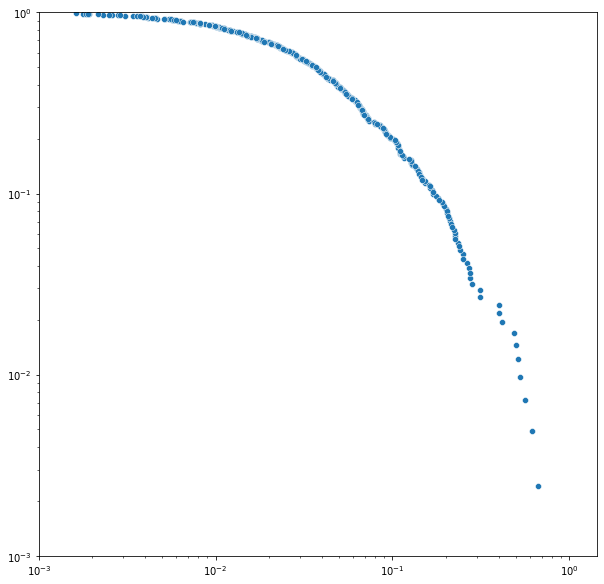

In [301]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = pos_returns, y = quantiles, ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left = 10**-3)
ax.set_ylim([10e-4,1])

In [302]:
neg_returns = abs(y.loc[y['next_day_return'] < 0].values.flatten())
quantiles = pd.qcut(neg_returns, q = len(neg_returns), labels=False)
quantiles = 1 - quantiles / max(quantiles)

(0.001, 1)

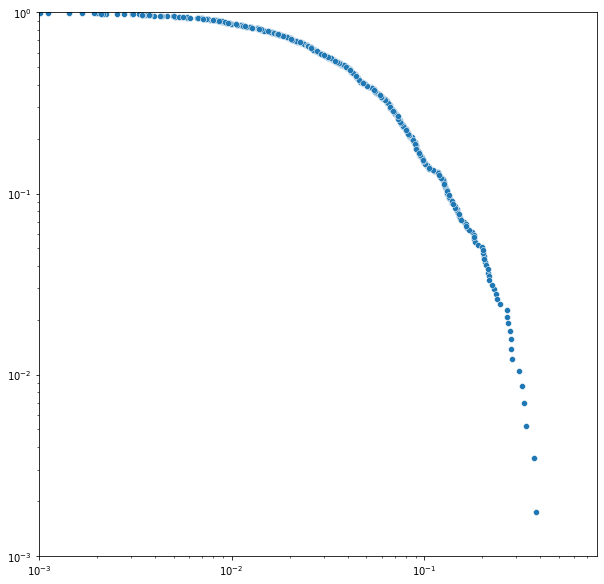

In [303]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = neg_returns, y = quantiles, ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left = 10**-3)
ax.set_ylim([10e-4,1])

In [318]:
from scipy.stats import powerlaw

In [362]:
from scipy.stats import lognorm

0.9797626689751207 -0.002246126612338079 0.03899521889667946
1.2051593835173127 -0.0010261765412220543 0.035907352923572514


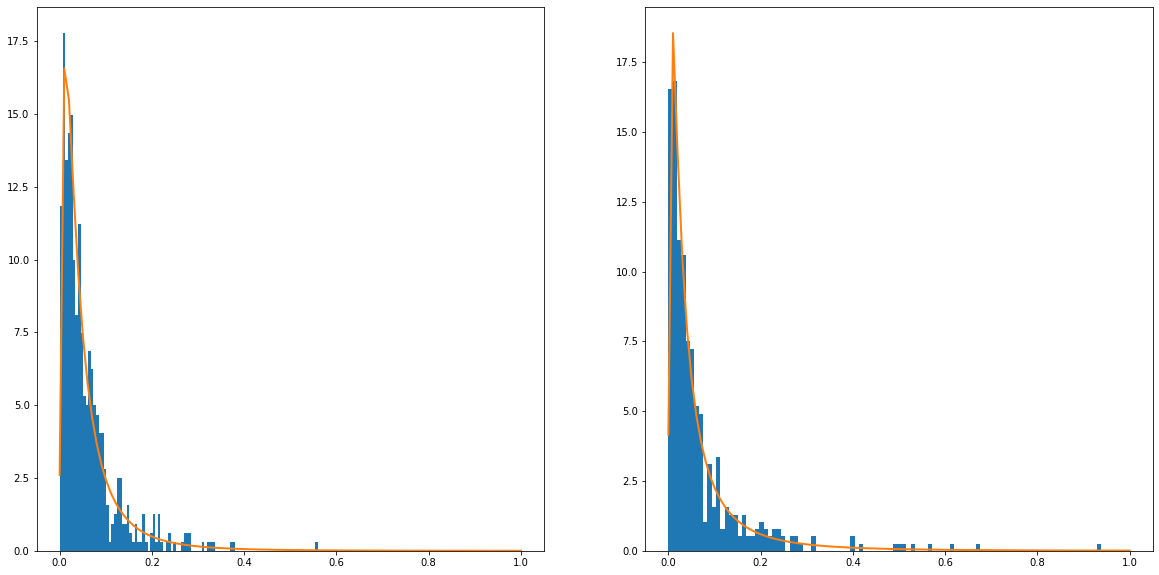

In [374]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
returns = [neg_returns, pos_returns]
for i, ax in enumerate(axs.flat):
    s, loc, scale = lognorm.fit(returns[i])
    print(s, loc, scale)
    ax.hist(returns[i], 100, density=True)
    x = np.linspace(0, 1, 100)
    ax.plot(x, lognorm(s, loc, scale).pdf(x), lw=2)

plt.show()

In [341]:
from scipy.stats import beta

In [342]:
a1, b1, loc1, scale1 = beta.fit(neg_returns)

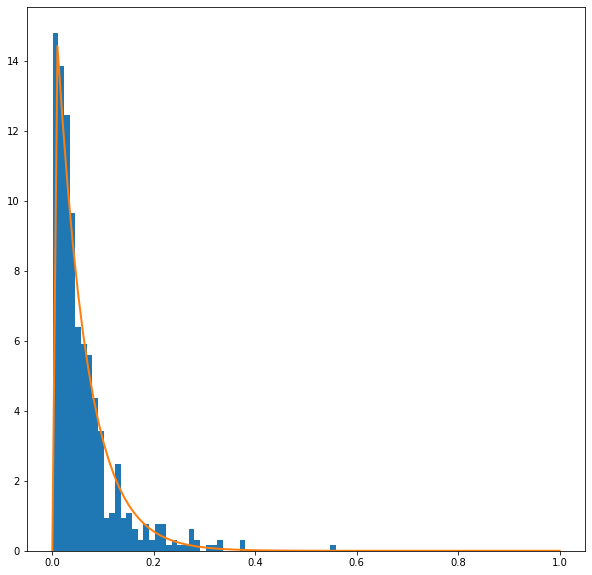

In [353]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(neg_returns, 50, density=True)
x = np.linspace(0, 1, 100)
ax.plot(x, beta(a1, b1, loc1, scale1).pdf(x), lw=2)

In [54]:
import statsmodels.api as sm

In [55]:
from scipy.stats import boxcox

In [420]:
X = df.drop(columns=['next_day_return'])
y = np.log(df[['next_day_return']] + 1)

In [421]:
# transform variables so residuals fit...

In [422]:
X['daily_return'] = X['daily_return'].apply(lambda x: np.exp(1 / np.sqrt(x + 1)))

In [423]:
X['daily_swing'] = X['daily_swing'].apply(lambda x: 1 / np.exp(x))

In [424]:
X['log_volume'] = boxcox((X['log_volume'] + 1).values)[0] #.apply(lambda x: np.exp(np.exp(x))) #np.exp(1 / np.sqrt(x + 1)))

In [425]:
X['avg_ticker_stocks_mentioned'] = boxcox((X['avg_ticker_stocks_mentioned'].apply(lambda x: np.log(x+1))).values)[0]

In [426]:
X['avg_ticker_reactions'] = boxcox((X['avg_ticker_reactions'].apply(lambda x: np.log(x+2))).values)[0]

In [427]:
X['avg_ticker_replies'] = boxcox((X['avg_ticker_replies'] + 1).values)[0]

In [428]:
X['perc_ticker_messages_RATIO'] = boxcox((X['perc_ticker_messages_RATIO'].apply(lambda x: x + 10)).values)[0]

In [429]:
X['avg_ticker_stocks_mentioned_RATIO'] = boxcox((X['perc_ticker_messages_RATIO'].apply(lambda x: np.log(x + 100))).values)[0]

In [430]:
X['message_clustering'] = boxcox((X['message_clustering'] + 1).values)[0]

In [431]:
X['perc_ticker_messages'] = X['perc_ticker_messages'].apply(lambda x: np.log(x))

In [432]:
X = sm.add_constant(X)

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# drop variables to see effect on VIF

In [434]:
X = X.drop(columns = ['avg_ticker_stocks_mentioned_RATIO'])

In [436]:
X = X.drop(columns = ['market_cap'])

In [438]:
X = X.drop(columns = ['perc_ticker_messages'])

In [441]:
X = X.drop(columns = ['daily_swing'])

In [412]:
X = X.drop(columns = ['perc_ticker_messages_RATIO'])

In [415]:
X = X.drop(columns = ['daily_return'])

In [416]:
X = X.drop(columns = ['log_volume'])

In [381]:
X = X.drop(columns = ['avg_ticker_reactions'])

In [386]:
X = X.drop(columns = ['avg_ticker_replies'])

In [387]:
X = X.drop(columns = ['avg_ticker_stocks_mentioned'])

In [388]:
X = X.drop(columns = ['most_active_user'])

In [389]:
X =  X.drop(columns = ['closing_price'])

In [390]:
X  = X.drop(columns =  ['message_clustering'])

In [442]:
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
                  index=X.columns)

const                          47343.930249
daily_return                       1.303253
log_volume                         1.541347
volume_diff                        1.444088
closing_price                      1.169997
ticker_len_ratio                   1.374514
avg_ticker_stocks_mentioned        1.111605
avg_ticker_replies                 1.554664
avg_ticker_reactions               1.183774
most_active_user                   1.571149
message_clustering                 1.744110
perc_ticker_messages_RATIO         1.072256
ticker_len_ratio_RATIO             1.170426
avg_ticker_replies_RATIO           1.233920
avg_ticker_reactions_RATIO         1.099207
most_active_user_RATIO             1.169568
message_clustering_RATIO           1.211477
dtype: float64

In [ ]:
# R2 is too low and data is transformed correctly, so there doesn't look like there's signal in this data...

In [443]:
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        next_day_return   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.340
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           3.13e-08
Time:                        01:10:29   Log-Likelihood:                 709.02
No. Observations:                 815   AIC:                            -1384.
Df Residuals:                     798   BIC:                            -1304.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
# remove variables that don't add to regression

In [445]:
X = X.drop(columns = ['volume_diff'])

In [447]:
X = X.drop(columns = ['avg_ticker_reactions'])

In [449]:
X = X.drop(columns = ['avg_ticker_replies_RATIO'])

In [451]:
X = X.drop(columns = ['avg_ticker_reactions_RATIO'])

In [453]:
X = X.drop(columns = ['most_active_user_RATIO'])

In [455]:
X = X.drop(columns = ['ticker_len_ratio'])

In [457]:
X = X.drop(columns = ['ticker_len_ratio_RATIO'])

In [459]:
X = X.drop(columns = ['avg_ticker_replies'])

In [461]:
X = X.drop(columns = ['closing_price'])

In [463]:
X = X.drop(columns = ['const'])

In [465]:
X = X.drop(columns = ['most_active_user'])

In [466]:
results = sm.OLS(y, X).fit() # the r squared is too low...
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        next_day_return   R-squared (uncentered):                   0.078
Model:                            OLS   Adj. R-squared (uncentered):              0.071
Method:                 Least Squares   F-statistic:                              11.39
Date:                Mon, 08 Feb 2021   Prob (F-statistic):                    2.98e-12
Time:                        01:14:08   Log-Likelihood:                          704.11
No. Observations:                 815   AIC:                                     -1396.
Df Residuals:                     809   BIC:                                     -1368.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [ ]:
# show that with all variables included, the residuals are acceptable

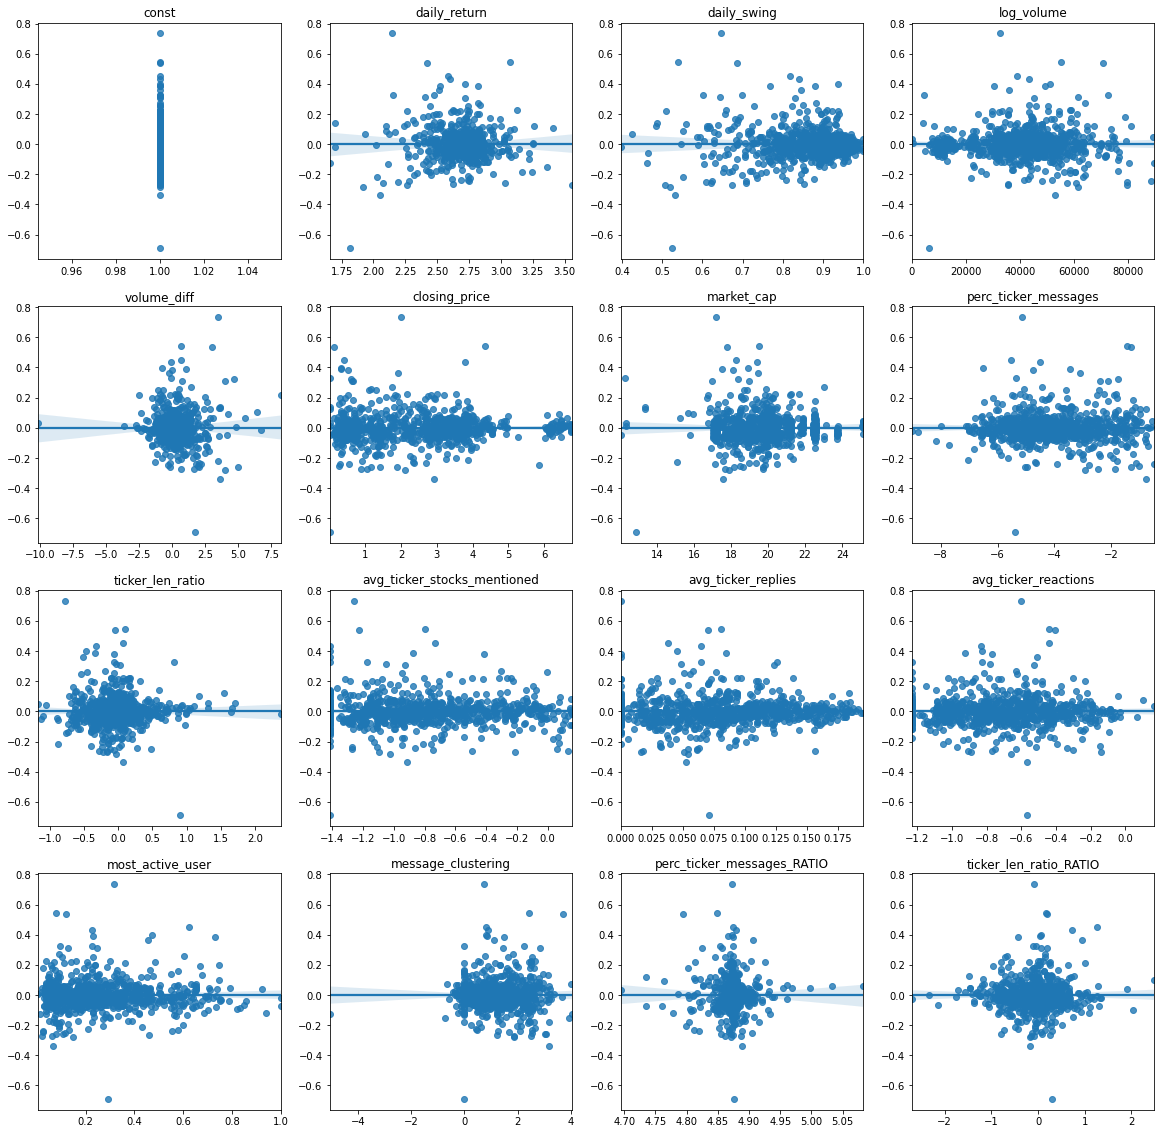

In [408]:
fig, axs = plt.subplots(4,4, figsize=(20,20))
cols = list(X.columns)

for i, ax in enumerate(axs.flat):
    sns.regplot(x = X[cols[i]].values, y = results.resid, ax=ax)
    ax.set_title(cols[i])

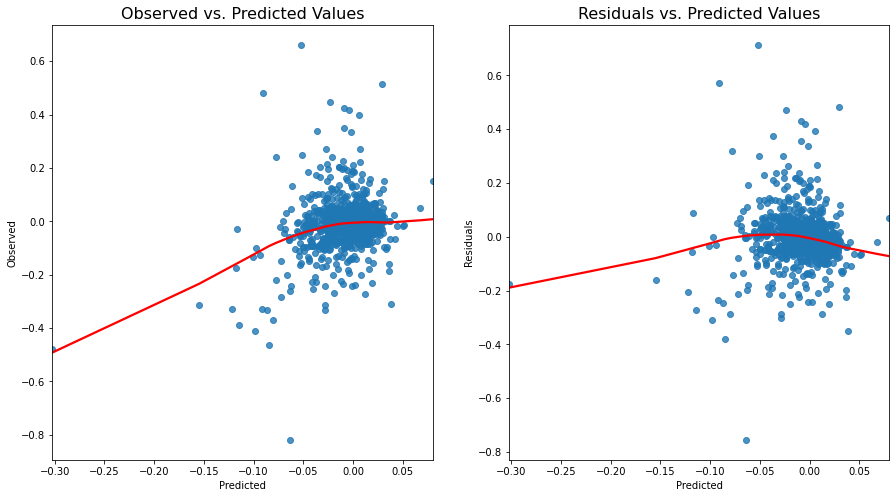

In [467]:
import seaborn as sns 
import matplotlib.pyplot as plt
# import statsmodels.stats.api as sms
# sns.set_style('darkgrid')
# sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2, figsize=(15,8))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(results, y)    

array([[<AxesSubplot:title={'center':'next_day_return'}>]], dtype=object)

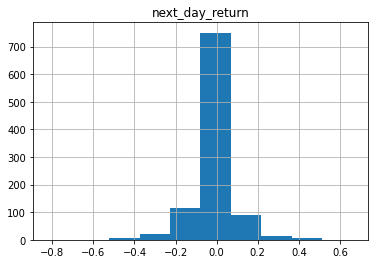

In [997]:
y.hist()

In [56]:
day = days_to_test[40]
df = stock_vip_free_chat.loc[stock_vip_free_chat['date'] == day].reset_index(drop=True)

In [57]:
gs = extract_general_stats_for_day(df)

In [79]:
ss = extract_stock_specific_stats(df, 'gme', day)

In [84]:
pd.concat([ss, gs], axis = 1)

daily_return  daily_swing  volume_ratio  swing_ratio  perc_ticker_messages  \
0     -0.206141     0.615969      0.675566     5.042322              0.221398   

   ticker_len_ratio  avg_stocks_mentioned  avg_ticker_replies  \
0          0.058819              1.125906            0.076127   

   avg_ticker_reactions  most_active_user  next_day_return  len_ratio  \
0              0.191025          0.040761         0.670958   0.714296   

   avg_stocks_mentioned  percent_ticker_messages  replies_ratio  \
0              1.132959                 0.310976       0.180075   

   reactions_ratio  users_ratio  biggest_ticker  
0         0.858078     0.562336        0.231879

In [58]:
gs

len_ratio  avg_stocks_mentioned  percent_ticker_messages  replies_ratio  \
0   0.714296              1.132959                 0.310976       0.180075   

   reactions_ratio  users_ratio  biggest_ticker  
0         0.858078     0.562336        0.231879

In [52]:
# ticker_counts = pd.DataFrame(pd.Series(all_tickers).value_counts()).reset_index().rename(columns={'index': 'ticker', 0: 'count'})

In [169]:
# time is relative to the number of ticker symbols sent scaled for active users in chat per day (moving avg)
# ie n_tickers = n_users / 100
stock_active_users = stock_vip_free_chat.groupby(pd.Grouper(key='timestamp',freq='1D')).apply(
    lambda group: len(set(group['author_id']))).reset_index().rename(columns={0: 'daily_active_users'}) #.set_index('timestamp')

In [170]:
stock_active_users['date'] = stock_active_users['timestamp'].apply(lambda d: d.date())

In [171]:
stock_active_users = stock_active_users.drop(columns = ['timestamp'])

In [180]:
stock_active_users

daily_active_users        date
0                   162  2020-09-22
1                   279  2020-09-23
2                   568  2020-09-24
3                   602  2020-09-25
4                   201  2020-09-26
..                  ...         ...
127                8166  2021-01-27
128               13682  2021-01-28
129               12787  2021-01-29
130                6201  2021-01-30
131                1815  2021-01-31

[132 rows x 2 columns]

In [155]:
#stock_vip_free_chat['date'] = stock_vip_free_chat['timestamp'].apply(lambda d: d.date())

In [179]:
stock_vip_free_chat = stock_vip_free_chat.merge(stock_active_users, 'left', on = ['date'])

In [175]:
stock_vip_free_chat['n_tickers'] = stock_vip_free_chat['tickers'].apply(lambda x: len(x))

In [184]:
np.mean(stock_vip_filtered['n_tickers'])

1.2122235970395263

In [185]:
stock_vip_filtered['group'] = 0

In [187]:
int(9.11)

9

In [191]:
prev_index = 0
current_index = int(stock_vip_filtered.loc[0, 'daily_active_users'] * 1.21) # 1.21 is mean number of tickers per message
start_times = []
end_times = []
list_of_tickers = []
while current_index < stock_vip_filtered.shape[0]:
    start_times.append(stock_vip_filtered.loc[prev_index, 'timestamp'])
    end_times.append(stock_vip_filtered.loc[current_index, 'timestamp'])
    local_tickers = [tick for sublist in stock_vip_filtered.loc[prev_index: current_index, 'tickers'] for tick in sublist]
    list_of_tickers.append(local_tickers)
    prev_index = current_index
    current_index = current_index + int(stock_vip_filtered.loc[current_index, 'daily_active_users'] * 1.21)

In [ ]:
# get the percentage of each stock in each 

In [199]:
tickers_as_dicts = []
for l in list_of_tickers:
    tickers_as_dicts.append(dict(pd.Series(l).value_counts() / len(l)))

In [201]:
stationary_percentages = pd.DataFrame({'start_time': start_times, 'end_time': end_times, 'tickers': tickers_as_dicts})

In [210]:
for t in tickers_of_interest:
    stationary_percentages[t] = 0

In [214]:
for i in range(stationary_percentages.shape[0]):
    d = stationary_percentages.loc[i, 'tickers']
    for key in d.keys():
        if key in stationary_percentages.columns:
            stationary_percentages.loc[i, key] = d[key]

In [215]:
stationary_percentages

start_time                         end_time  \
0   2020-09-22 08:50:24.362000+00:00 2020-09-22 23:36:19.280000+00:00   
1   2020-09-22 23:36:19.280000+00:00 2020-09-23 17:45:21.329000+00:00   
2   2020-09-23 17:45:21.329000+00:00 2020-09-23 20:12:45.154000+00:00   
3   2020-09-23 20:12:45.154000+00:00 2020-09-24 13:09:54.336000+00:00   
4   2020-09-24 13:09:54.336000+00:00 2020-09-24 17:33:41.246000+00:00   
..                               ...                              ...   
242 2021-01-27 15:05:14.472000+00:00 2021-01-27 18:23:36.680000+00:00   
243 2021-01-27 18:23:36.680000+00:00 2021-01-27 22:20:04.447000+00:00   
244 2021-01-27 22:20:04.447000+00:00 2021-01-28 06:27:15.639000+00:00   
245 2021-01-28 06:27:15.639000+00:00 2021-01-28 22:08:13.404000+00:00   
246 2021-01-28 22:08:13.404000+00:00 2021-01-30 03:47:49.474000+00:00   

                                               tickers       amc       nio  \
0    {'tsla': 0.102803738317757, 'pt': 0.0373831775...  0.000000  0.009346   
1    {'spi': 0.1932367149758454, 'uone': 0.12560386...  0.000000  0.019324   
2    {'spi': 0.3789173789173789, 'uone': 0.17094017...  0.000000  0.005698   
3    {'uone': 0.16292134831460675, 'spi': 0.1404494...  0.002809  0.011236   
4    {'uone': 0.2857142857142857, 'sunw': 0.2653061...  0.000000  0.013605   
..                                                 ...       ...       ...   
242  {'amc': 0.5451273381687299, 'nok': 0.141517151...  0.545127  0.000982   
243  {'amc': 0.3333986748735641, 'nakd': 0.23275963...  0.333399  0.002039   
244  {'amc': 0.34772542125798567, 'nok': 0.29022852...  0.347725  0.001929   
245  {'amc': 0.3492063492063492, 'nakd': 0.14239165...  0.349206  0.003165   
246  {'amc': 0.5074574574574574, 'nok': 0.107007007...  0.507457  0.003053   

         sndl       nok       zom      nakd      cciv  ...      dgly  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
1    0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
2    0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.002849   
3    0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.014045   
4    0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
..        ...       ...       ...       ...       ...  ...       ...   
242  0.006490  0.141517  0.001963  0.100453  0.007689  ...  0.000000   
243  0.004705  0.204846  0.000941  0.232760  0.007959  ...  0.000157   
244  0.042447  0.290229  0.001115  0.167217  0.008618  ...  0.000000   
245  0.058698  0.139273  0.002653  0.142392  0.009263  ...  0.000000   
246  0.035435  0.107007  0.001752  0.085686  0.007457  ...  0.000000   

           rh      itll  veru      uwmc      fcel      cars      gnus  \
0    0.000000  0.018692   0.0  0.000000  0.000000  0.023364  0.000000   
1    0.004831  0.019324   0.0  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.002849   0.0  0.000000  0.000000  0.002849  0.000000   
3    0.000000  0.008427   0.0  0.000000  0.000000  0.000000  0.000000   
4    0.001361  0.004082   0.0  0.000000  0.000000  0.001361  0.001361   
..        ...       ...   ...       ...       ...       ...       ...   
242  0.000436  0.000600   0.0  0.001309  0.000218  0.000000  0.001472   
243  0.000392  0.000314   0.0  0.000392  0.000078  0.000157  0.025522   
244  0.000214  0.000643   0.0  0.000257  0.000000  0.000000  0.000729   
245  0.004748  0.000698   0.0  0.000419  0.000047  0.000093  0.002560   
246  0.013013  0.001351   0.0  0.000450  0.000150  0.000050  0.001201   

          dpw      cbat  
0    0.000000  0.000000  
1    0.000000  0.004831  
2    0.008547  0.059829  
3    0.019663  0.002809  
4    0.000000  0.005442  
..        ...       ...  
242  0.000000  0.000273  
243  0.000000  0.000157  
244  0.000000  0.000043  
245  0.000000  0.000140  
246  0.000100  0.000100  

[247 rows x 61 columns]

In [257]:
stationary_percentages_filtered = stationary_percentages.drop(columns=['start_time', 'end_time','tickers'])[230:].reset_index(drop=True)

In [258]:
stocks_of_interest = pd.DataFrame(list(zip(stationary_percentages_filtered.columns, stationary_percentages_filtered.apply(
    lambda x: max(x), axis = 0)))).sort_values(by=1, ascending=False).reset_index(drop=True)[:7][0].to_list()

In [259]:
stationary_percentages_filtered = stationary_percentages_filtered[stocks_of_interest]

In [261]:
sns.set_style('white')
sns.set_context('notebook')

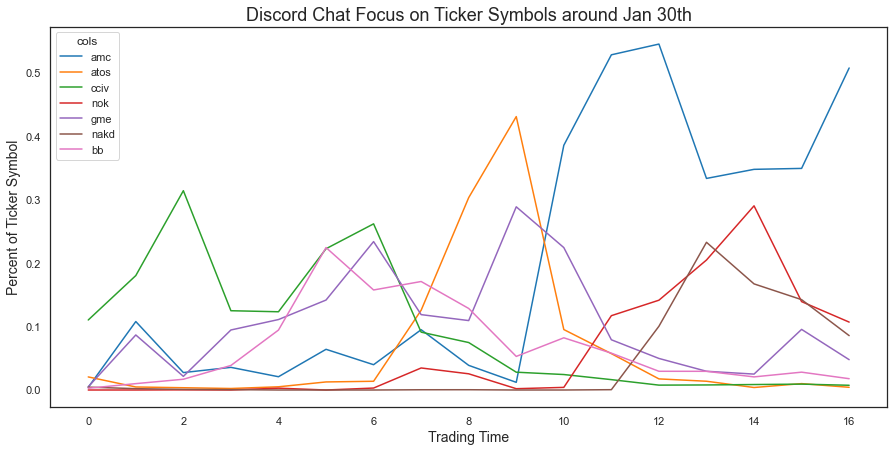

In [265]:
fig, ax = plt.subplots(figsize=(15,7))
df = stationary_percentages_filtered.reset_index()
df = df.melt('index', var_name='cols', value_name='vals')
sns.lineplot(x="index", y="vals", hue='cols', data=df, ax=ax)
ax.set_xlabel('Trading Time', fontsize=14)
ax.set_ylabel('Percent of Ticker Symbol', fontsize=14)
ax.set_title('Discord Chat Focus on Ticker Symbols around Jan 30th', fontsize=18)
plt.show()

In [182]:
stock_vip_filtered = stock_vip_free_chat.loc[stock_vip_free_chat['n_tickers'] > 0].reset_index(drop=True)

<AxesSubplot:>

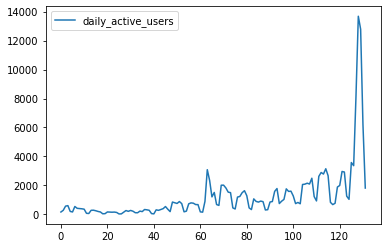

In [173]:
stock_active_users.plot()

In [139]:
stock_vip_free_chat.loc[0, 'timestamp'].date()

'2020-09-22'

In [207]:
ticker_subset = ticker_counts.loc[ticker_counts['count'] > 1000]

In [208]:
ticker_subset

ticker  count
0     amc  58729
1     nio  42802
2    sndl  26110
3     nok  22008
4     zom  19868
5    nakd  19440
6    cciv  19192
7    ipoc  14716
8     gme  13264
9    pltr  11474
10   clov  10208
11   bngo   9157
12   jagx   8628
13     bb   8445
14   atos   7897
15   ghiv   6483
16   ctrm   6146
17    app   5951
18    sls   5523
19    fsr   5213
20   idex   4701
21   glsi   4694
22     pt   4346
23    acb   4317
24   govx   4056
25   crsr   3433
26   tsla   3333
27   biol   3115
28    cuz   3107
29   xpev   2990
30   haha   2952
31   mara   2814
32    tmr   2629
33    pre   2500
34   chek   2483
35    ayo   2230
36   uone   2066
37   ocgn   1959
38    oeg   1923
39   immp   1916
40   nxtd   1818
41    xrp   1792
42    abt   1722
43   lazr   1626
44   info   1510
45   abnb   1454
46   spce   1375
47    pfe   1310
48   dgly   1291
49     rh   1252
50   itll   1200
51   veru   1171
52   uwmc   1169
53   fcel   1108
54   cars   1082
55   gnus   1078
56    dpw   1046
57   cbat   1002

In [209]:
tickers_of_interest = ticker_subset['ticker'].to_list()

In [69]:
pd.DataFrame(columns = tickers_of_interest, index = [0], data = 0)

amc  nio  sndl  nok  zom  nakd  cciv  ipoc  gme  pltr  clov
0    0    0     0    0    0     0     0     0    0     0     0

In [ ]:
# want it to be stationary... so looking at percentage gme per 1000 words sent (could do characters)

In [75]:
def get_group_counts(group, tickers_of_interest):
    group = group.reset_index(drop=True)
    tickers_as_set = set(tickers_of_interest)
    df = pd.DataFrame(columns = tickers_of_interest, index = [0], data = 0)
    # want to get counts for each ticker in tickers of interest in o(n)
    for i in range(group.shape[0]):
        for tick in group.loc[i, 'tickers']:
            if tick in tickers_as_set:
                df.loc[0, tick] += 1
    
    df['n_messages'] = group.shape[0]
    df['total_text'] = np.sum(group['message_len'])
    df['avg_message_len'] = np.mean(group['message_len'])
    
    return df

In [ ]:
messages

In [76]:
message_counts = stock_vip_free_chat.groupby(pd.Grouper(key='timestamp', freq='30min')).apply(
    lambda group: get_group_counts(group, tickers_of_interest)).reset_index(level=0).reset_index(drop=True)

In [77]:
message_counts

timestamp  amc  nio  sndl  nok  zom  nakd  cciv  ipoc  \
0    2020-09-22 08:30:00+00:00    0    0     0    0    0     0     0     0   
1    2020-09-22 09:00:00+00:00    0    0     0    0    0     0     0     0   
2    2020-09-22 09:30:00+00:00    0    0     0    0    0     0     0     0   
3    2020-09-22 10:00:00+00:00    0    0     0    0    0     0     0     0   
4    2020-09-22 10:30:00+00:00    0    0     0    0    0     0     0     0   
...                        ...  ...  ...   ...  ...  ...   ...   ...   ...   
6280 2021-01-31 04:30:00+00:00   37    2     0    2    0     1     4     0   
6281 2021-01-31 05:00:00+00:00   53    0     1    4    0     4     4     0   
6282 2021-01-31 05:30:00+00:00   64    0     5   12    0     5     0     0   
6283 2021-01-31 06:00:00+00:00   37    0     5    6    0     5     6     0   
6284 2021-01-31 06:30:00+00:00   17    0     0    6    1     2     1     0   

      gme  pltr  clov  n_messages  total_text  avg_message_len  
0       0     0     0          87        1809        20.793103  
1       0     0     0          31        1173        37.838710  
2       0     0     0          24         808        33.666667  
3       0     0     0          11         265        24.090909  
4       0     0     0           6         220        36.666667  
...   ...   ...   ...         ...         ...              ...  
6280    9     0     1         577       20840        36.117851  
6281   11     0     0         686       23134        33.723032  
6282   16     0     0         596       23151        38.843960  
6283    6     0     0         633       24463        38.646130  
6284    1     0     0         601       16536        27.514143  

[6285 rows x 15 columns]

<AxesSubplot:xlabel='timestamp', ylabel='vals'>

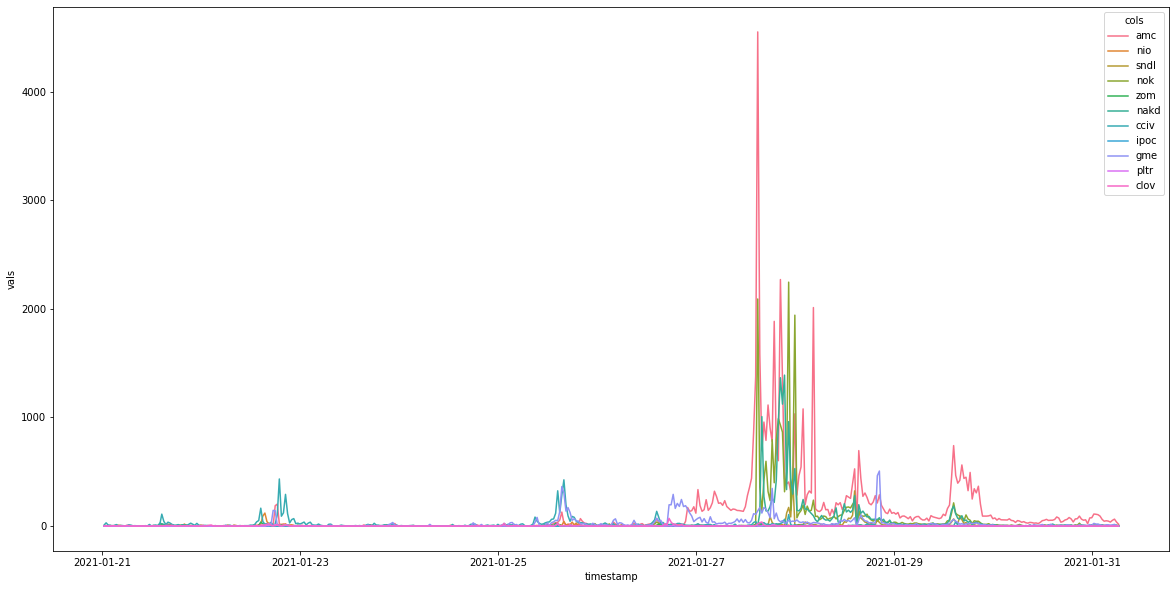

In [79]:
fig, ax = plt.subplots(figsize=(20,10))
df = message_counts.drop(columns=['n_messages', 'total_text','avg_message_len']).loc[
        message_counts['timestamp'] > '2021-01-21'].reset_index(drop=True)
df = df.melt('timestamp', var_name='cols', value_name='vals')
sns.lineplot(x="timestamp", y="vals", hue='cols', data=df, ax=ax)

In [80]:
message_count_percentages = message_counts
for col in tickers_of_interest:
    message_count_percentages[col] /= message_count_percentages['total_text']

<AxesSubplot:xlabel='timestamp', ylabel='vals'>

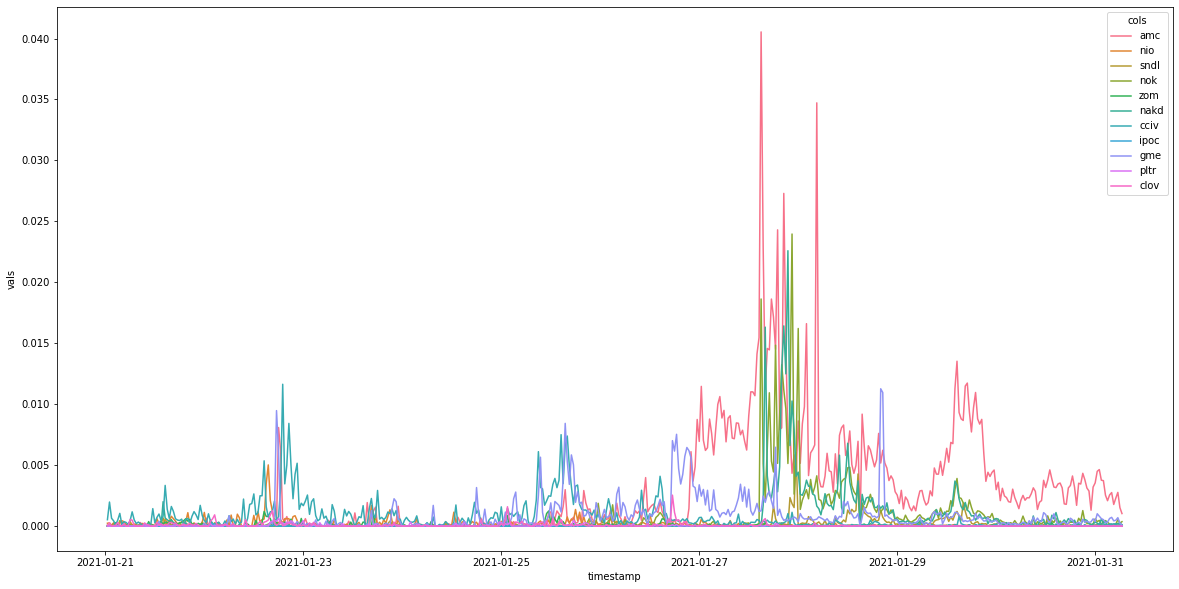

In [89]:
fig, ax = plt.subplots(figsize=(20,10))
df = message_count_percentages.drop(columns=['n_messages', 'total_text','avg_message_len']).loc[
        message_count_percentages['timestamp'] > '2021-01-21'].reset_index(drop=True)
df = df.melt('timestamp', var_name='cols', value_name='vals')
sns.lineplot(x="timestamp", y="vals", hue='cols', data=df, ax=ax)

<AxesSubplot:xlabel='timestamp', ylabel='gme'>

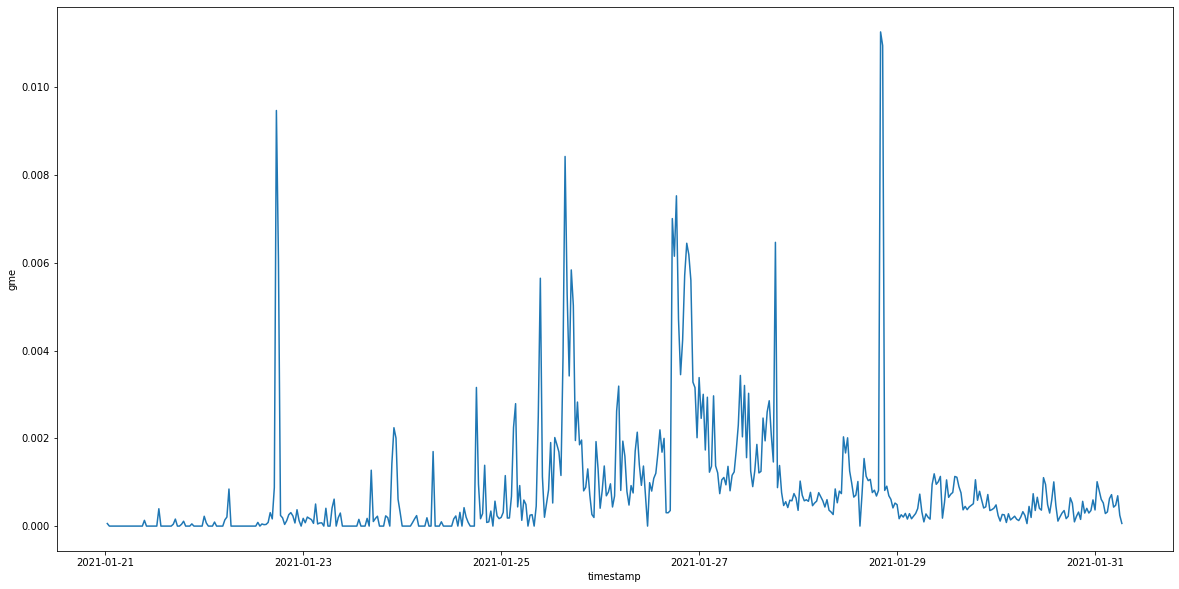

In [111]:
fig, ax = plt.subplots(figsize=(20,10))
df = message_count_percentages.loc[message_count_percentages['timestamp'] > '2021-01-21'].reset_index(drop=True)
# df['gme'] = df['gme'].apply(lambda x: np.log(x+1))
sns.lineplot(x="timestamp", y="gme", data=df, ax=ax)

In [11]:
# import yfinance as yf

In [53]:
# determine if ticker symbol exists... create dict of non ticker words for future
# all_non_tickers = []
# for ticker in ticker_counts['ticker']:
#     t = yf.Ticker(ticker)
#     print('-',end='')
#     try:
#         x = t.dividends
#     except:
#         all_non_tickers.append(ticker)

In [15]:
# import pickle
# with open('non_tickers.pkl', 'wb') as f:
#     pickle.dump(all_non_tickers, f)

In [ ]:
# sense ticker symbols in chat

In [26]:
data = json.load(open('stock_vip.json'))

In [124]:
bot_messages = messages.loc[messages['is_bot'] == True].reset_index(drop=True)
messages = messages.loc[messages['is_bot'] == False].reset_index(drop=True)

In [76]:
# def is_gamestop(s):
#     if 'gme' in s.lower() or 'gamestop' in s.lower():
#         return True
#     return False

# def is_amc(s):
#     if 'amc' in s.lower():
#         return True
#     return False

# def is_doge(s):
#     if 'doge' in s.lower():
#         return True
#     return False

In [77]:
messages['gme'] = messages['content'].apply(lambda s: is_gamestop(s))
messages['amc'] = messages['content'].apply(lambda s: is_amc(s))
messages['doge'] = messages['content'].apply(lambda s: is_doge(s))

In [85]:
sum(messages['gme'])

5014

In [126]:
message_counts = messages.groupby(pd.Grouper(key='timestamp', freq='30min')).apply(
    lambda group: get_group_counts(group)).reset_index(level=0).reset_index(drop=True)

<AxesSubplot:xlabel='timestamp', ylabel='vals'>

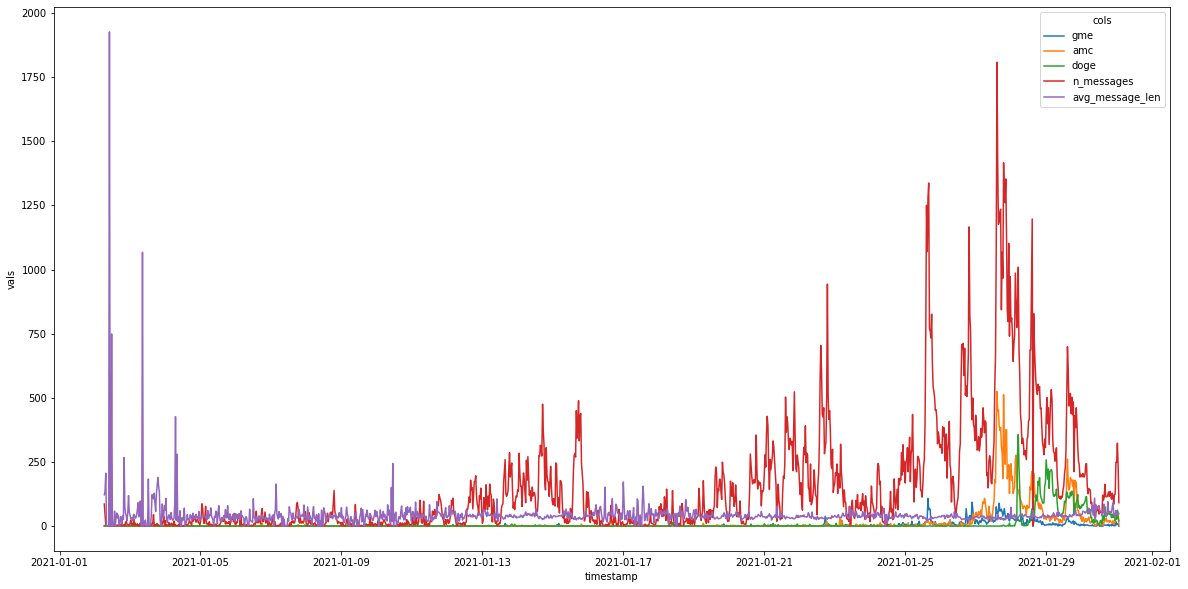

In [127]:
fig, ax = plt.subplots(figsize=(20,10))
# sns.lineplot(x='timestamp', y = 'gme', color='indianred', ax=ax)
# sns.lineplot(x='timestamp', y = 'amc', color='b', ax=ax)\
# sns.lineplot(x='timestamp', y = 'amc', color='b', ax=ax)\
df = message_counts.melt('timestamp', var_name='cols',  value_name='vals')
sns.lineplot(x="timestamp", y="vals", hue='cols', data=df, ax=ax)

In [128]:
def get_percent_counts(row, col_of_interest):
    return 0 if not row['n_messages'] else row[col_of_interest] / row['n_messages']

In [129]:
message_counts['percent_gme'] = message_counts.apply(lambda row: get_percent_counts(row, 'gme'), axis=1)
message_counts['percent_amc'] = message_counts.apply(lambda row: get_percent_counts(row, 'amc'), axis=1)
message_counts['percent_doge'] = message_counts.apply(lambda row: get_percent_counts(row, 'doge'), axis=1)

<AxesSubplot:>

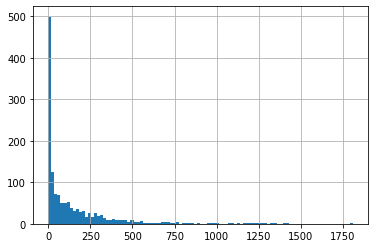

In [137]:
message_counts['n_messages'].hist(bins=100)

In [140]:
message_percentages = message_counts.drop(columns = ['gme', 'amc', 'doge', 'avg_message_len'])
message_percentages['n_messages'] = message_percentages['n_messages'].apply(lambda x: np.log(x + 1) / 8)

In [150]:
users = pd.DataFrame(messages['author_id'].value_counts()).reset_index().rename(columns={'index': 'author_id', 'author_id': 'count'})

In [152]:
def get_perc_for_user(df, col_of_interest):
    return sum(df[col_of_interest]) / df.shape[0]

In [153]:
users['perc_gme'] = users['author_id'].apply(lambda x: get_perc_for_user(messages.loc[messages['author_id'] == x], 'gme'))

In [154]:
users['perc_amc'] = users['author_id'].apply(lambda x: get_perc_for_user(messages.loc[messages['author_id'] == x], 'amc'))

In [155]:
users['perc_doge'] = users['author_id'].apply(lambda x: get_perc_for_user(messages.loc[messages['author_id'] == x], 'doge'))

In [162]:
users = users.loc[users['count'] > 30].reset_index(drop=True)

<AxesSubplot:>

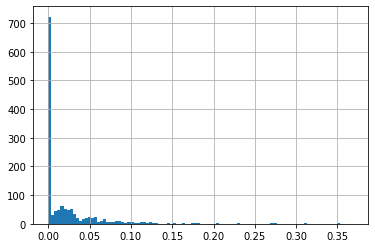

In [165]:
users['perc_gme'].hist(bins = 100)

<AxesSubplot:>

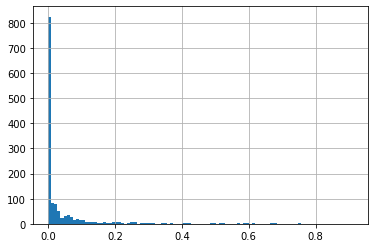

In [166]:
users['perc_doge'].hist(bins = 100)

<AxesSubplot:>

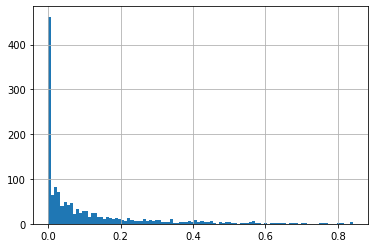

In [167]:
users['perc_amc'].hist(bins = 100)

<AxesSubplot:xlabel='timestamp', ylabel='vals'>

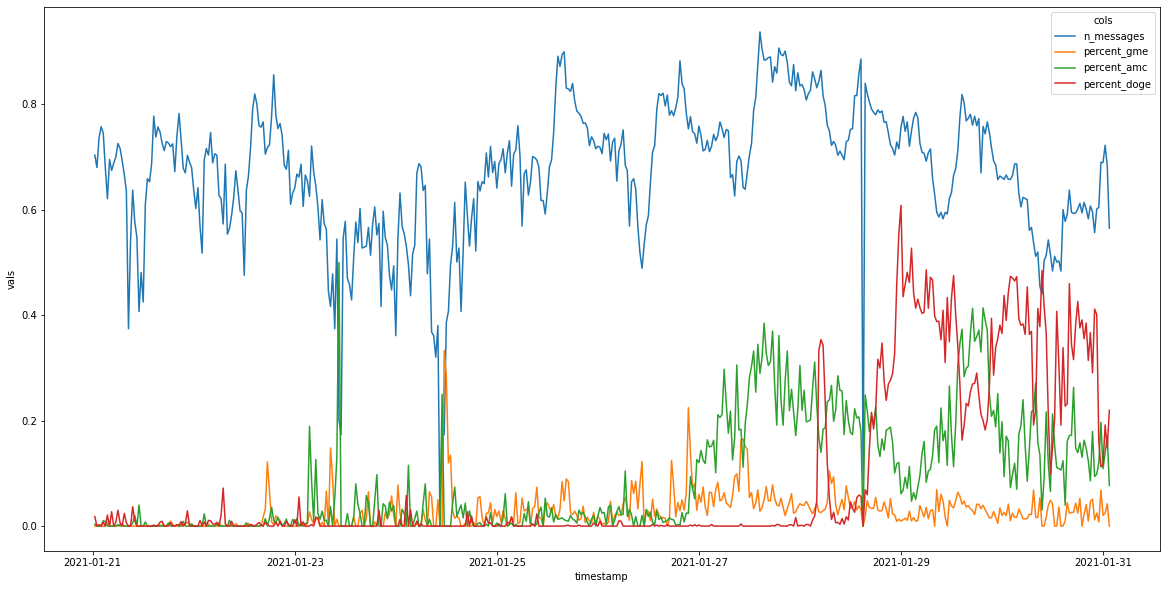

In [141]:
fig, ax = plt.subplots(figsize=(20,10))
df = message_percentages.loc[message_percentages['timestamp'] > '2021-01-21']
df = df.melt('timestamp', var_name='cols', value_name='vals')
sns.lineplot(x="timestamp", y="vals", hue='cols', data=df, ax=ax)